In [ ]:
import cv2
import numpy as np
import math
import os
import matplotlib.pyplot as plt
current_path=r"F:\PBL\yolact"
data_path=os.path.join(current_path,'data','mahjong')
def angle(pt1, pt2, pt0) -> float:
    dx1 = float(pt1[0, 0] - pt0[0, 0])
    dy1 = float(pt1[0, 1] - pt0[0, 1])
    dx2 = float(pt2[0, 0] - pt0[0, 0])
    dy2 = float(pt2[0, 1] - pt0[0, 1])
    v = math.sqrt((dx1*dx1 + dy1*dy1)*(dx2*dx2 + dy2*dy2))
    return (dx1*dx2 + dy1*dy2) / v

In [17]:
def get_contours(path):
    if type(path) is str:
        img = cv2.imread(path) 
    else:
        img=path.copy()
    
    img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    ret, im_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(im_otsu, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) 

    [h,w]=img_gray.shape
    min_area=h//20*w//20
    max_area=h//10*9*w//10*9
    print(f'min:{min_area},max:{max_area}')
    cut_points=[]
    for i, cnt in enumerate(contours):
        # 輪郭の周囲に比例する精度で輪郭を近似する
        arclen = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, arclen*0.005, True)
        # 凸性の確認
        area = abs(cv2.contourArea(approx))
        print('before if',area)
        if area > min_area and area < max_area:
                print('if')
                rcnt = approx.reshape(-1, 2)
                point=([w,h],[0,0])
                for i in rcnt:
                    if i[0] < point[0][0]:
                        point[0][0]=i[0]
                    if i[0] > point[1][0]:
                        point[1][0]=i[0]
                    if i[1] < point[0][1]:
                        point[0][1]=i[1]
                    if i[1] > point[1][1]:
                        point[1][1]=i[1]
                cut_points.append(point)
                image=cv2.polylines(img, [rcnt], True, (0, 0, 255),
                              thickness=5, lineType=cv2.LINE_8)
    return image,cut_points

In [ ]:
#緑領域抽出
def get_green(path):
    if type(path) is str:
        img = cv2.imread(path)
    else:
        img=path.copy()
    image=img
    height, width, channels = img.shape[:3]
    hsvLower = np.array([30, 50, 40])    # 抽出する色の下限(HSV)
    hsvUpper = np.array([90, 255, 255])    # 抽出する色の上限(HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # 画像をHSVに変換
    hsv_mask = cv2.inRange(hsv, hsvLower, hsvUpper)    # HSVからマスクを作成
    kernel = np.ones((3, 3), np.uint8)
    hsv_mask = cv2.morphologyEx(
        hsv_mask, cv2.MORPH_OPEN, kernel, iterations=3)  # クロージング
    kernel = np.ones((3, 3), np.uint8)
    hsv_mask = cv2.morphologyEx(
        hsv_mask, cv2.MORPH_CLOSE, kernel, iterations=20)  # クロージング
    # 輪郭取得
    contours, _ = cv2.findContours(
        hsv_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    [h,w]=hsv_mask.shape
    min_area=h//3*w//3
    cut_points=[]
    for i, cnt in enumerate(contours):
        # 輪郭の周囲に比例する精度で輪郭を近似する
        arclen = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, arclen*0.1, True)
        # 凸性の確認
        area = abs(cv2.contourArea(approx))
        if approx.shape[0] == 4 and area > min_area  and cv2.isContourConvex(approx):
            maxCosine = 0
            for j in range(2, 5):
                # 辺間の角度の最大コサインを算出
                cosine = abs(angle(approx[j % 4], approx[j-2], approx[j-1]))
                maxCosine = max(maxCosine, cosine)

            # すべての角度の余弦定理が小さい場合
            # （すべての角度は約90度です）次に、quandrangeを書き込みます
            # 結果のシーケンスへの頂点
            if maxCosine < 0.5:
                rcnt = approx.reshape(-1, 2)
                point=([width,height],[0,0])
                for i in rcnt:
                    if i[0] < point[0][0]:
                        point[0][0]=i[0]
                    if i[0] > point[1][0]:
                        point[1][0]=i[0]
                    if i[1] < point[0][1]:
                        point[0][1]=i[1]
                    if i[1] > point[1][1]:
                        point[1][1]=i[1]
                cut_points=point
                image=cv2.polylines(img, [rcnt], True, (0, 0, 255),
                              thickness=2, lineType=cv2.LINE_8)
    return image,cut_points


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
path=r"F:\PBL\yolact\data\mahjong\WIN_20230303_14_53_08_Pro.mp4"
video=cv2.VideoCapture(path)
video.set(cv2.CAP_PROP_POS_FRAMES, video.get(cv2.CAP_PROP_FRAME_COUNT)//2)
_,im=video.read()
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()
video.release()

In [ ]:
_,point=get_green(im)
print(point)
if len(point)>0:
    img=im.copy()
    # im1,im2=get_contours(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()

In [ ]:
def draw_line(img, theta, rho):
    h, w = img.shape[:2]
    # 直線が垂直のとき
    if np.isclose(np.sin(theta), 0):
        x1, y1 = rho, 0
        x2, y2 = rho, h
    # 直線が垂直じゃないとき
    else:
        # 直線の式を式変形すればcalc_yの式がもとまる(解説を後述します)．
        calc_y = lambda x: rho / np.sin(theta) - x * np.cos(theta) / np.sin(theta)
        x1, y1 = 0, calc_y(0)
        x2, y2 = w, calc_y(w)
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    # 直線を描画
    cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

def all_lines(img,im_lines):
    img=img.copy()
    for line in im_lines:
        rho, theta=line[0]
        draw_line(img,theta,rho)
    return img


In [ ]:
_,point=get_green(im)
print(point)
if len(point)>0:
    img=im.copy()
    img=img[point[0][1]:point[1][1],point[0][0]:point[1][0],:]
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()
    canny_img  = cv2.Canny(img,   # 入力画像
                       10,    # 2段階の閾値処理で利用する低い閾値
                       180    # 2段階の閾値処理で利用する高い閾値
                      )
    fld=cv2.createFastLineDetector(10,1.41421356,50,50,3,False)
    lines=fld.detext(canny_img)
    line_img=fld.drawSegment(img,lines)
    plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()

In [ ]:
#画像の標準化
def img_normal(img):
    img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(16, 16))
    v = clahe.apply(v)
    hsv = cv2.merge((h,s,v))
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
def line_length(seg):
    x=(int(seg[0])-int(seg[2]))
    y=(int(seg[1])-int(seg[3]))
    return (x**2+y**2)**(1/2)
lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_STD)
bgr = cv2.imread(os.path.join(data_path,'mahjong_calculation','00000.png'))
# bgr=img_normal(bgr)
bgr=im.copy()
bgr,point=get_green(bgr)
bgr=bgr[point[0][1]:point[1][1],point[0][0]:point[1][0],:]

mono = cv2.cvtColor( bgr, cv2.COLOR_BGR2GRAY )
lines, width, prec, nfs = lsd.detect( cv2.Canny(mono, 50,120 ) )
(h,w,_)=bgr.shape
img_white = np.ones((h,w),np.uint8)*255
print(lines[0])
for i in range(len(lines)):
    seg = lines[i][0]
    if line_length(seg)>40:
        cv2.line(img_white, (int(seg[0]), int(seg[1])), (int(seg[2]), int(seg[3])), (0,0,255), 1)
plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_white, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
path=os.getcwd()
im_path=os.path.join(path,'data','mahjong','sample.jpg')
im_path=r'F:\PBL\yolact\data\mahjong\WIN_20230303_12_56_43_Pro\frame10000.png'

im=cv2.imread(im_path)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()
_,point=get_green(im)
print(point)
if len(point)>0:
    img=im.copy()
    img=img[point[0][1]:point[1][1],point[0][0]:point[1][0],:]
    print(img.shape)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()


min:330,max:107010
before if 43096.0
if
[([59, 22], [304, 217])]


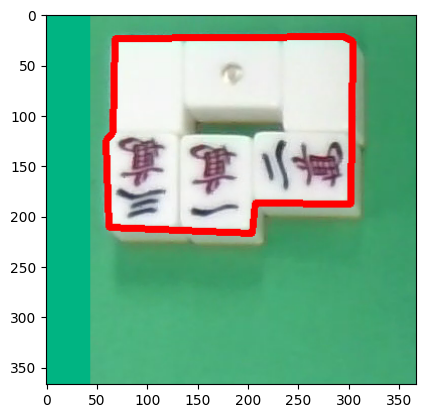

In [18]:
import os
import matplotlib.pyplot as plt
path=os.getcwd()
im_path=os.path.join(path,'data','mahjong','mahjong_calculation','00000.png')
im_path=r"F:\PBL\yolact\data\mahjong\sample\naki.png"
im1,point=get_contours(im_path)
print(point)
#画像の表示
plt.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()


In [ ]:
import os
import glob
import cv2
import matplotlib.pyplot as plt
folder=r"F:\PBL\yolact\data\mahjong\sample"
for path in glob.glob(os.path.join(folder,'*')):
    img=cv2.imread(path)
    h,w,_=img.shape
    if h>w:
        w_pad=h-w
        h_pad=0
    else:
        w_pad=0
        h_pad=w-h
    color = (130,180,0)
    img_pad = cv2.copyMakeBorder(img, h_pad, 0, w_pad, 0, cv2.BORDER_CONSTANT, value=color)
    cv2.imwrite(path,img_pad)
    
    




In [ ]:
import glob
import re
from tqdm import tqdm
path=r"F:\PBL\yolact\data\mahjong\WIN_*.mp4"
sec=5
save_path=r"F:\PBL\yolact\data\mahjong"
for video_path in glob.glob(path):
    video=cv2.VideoCapture(video_path)
    folder_path=os.path.join(save_path,re.sub('.mp4','',os.path.basename(video_path)))
    os.makedirs(folder_path,exist_ok=True)
    print(os.path.basename(video_path))
    for i in tqdm(range(0,int(video.get(cv2.CAP_PROP_FRAME_COUNT)),int(video.get(cv2.CAP_PROP_FPS)*sec))):
        if os.path.isfile(os.path.join(folder_path,f'frame{i}.png')):
            continue
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, img=video.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(folder_path,f'frame{i}.png'),img)
    video.release()


In [16]:
from PIL import Image
import cv2
import torch
import numpy as np
from utils.augmentations import BaseTransform, FastBaseTransform, Resize

# List of image paths
image_paths = ['00001.png', '00002.png', '00003.png']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load images and convert to tensors
images = [cv2.imread(path) for path in image_paths]
frames = [torch.from_numpy(img).to(device).float() for img in images]
batch = torch.stack(frames)
batch = FastBaseTransform()(batch)

In [18]:
type(batch)


torch.Tensor

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


c:\Users\kato\anaconda3\envs\yolact\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
import torch
from yolact import Yolact
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAINED_MODEL=r"weights\yolact_base_54_800000.pth"
# yolact_net is your Yolact model, images is your batch of images
net = Yolact()
net.load_weights(TRAINED_MODEL)
net.eval()
net = net.to(device)
net.detect.use_fast_nms = True
net.detect.use_cross_class_nms = False

# Assuming images is your batch of images
with torch.no_grad():
    preds = net(batch)

c:\Users\kato\anaconda3\envs\yolact\lib\site-packages\torch\jit\_recursive.py:222: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
c:\Users\kato\anaconda3\envs\yolact\lib\site-packages\torch\jit\_recursive.py:222: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
c:\Users\kato\anaconda3\envs\yolact\lib\site-packages\torch\jit\_recursive.py:222: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [24]:
preds[3]

IndexError: list index out of range

In [11]:
import os 
import glob
import cv2
import re

folder=r"F:\kato\mahjong\save_riichi"
class_names=['0','1']
for class_name in class_names:
    folder_path=os.path.join(folder,class_name)
    for path in glob.glob(os.path.join(folder_path,'*.png')):
        file_name=os.path.basename(path)
        player_num=re.sub('riichi','',re.sub('_.*','',file_name))
        player_num=int(player_num)
        if player_num%2==0:
            img=cv2.imread(path)
            img=cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
            cv2.imwrite(path,img)

        